In [52]:
import pandas as pd
import numpy as np



# from scipy.stats import spearmanr, rankdata
# from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras



In [53]:
def load_data(path):

    files = os.listdir(f'{path}\\img\\data\\')
    image = np.empty((len(files), 50, 50, 1))
    sample = []
    id = []
    for i in range(len(files)):
        if files[i].split('.')[1] == 'txt':
            id.append(i)
            data = pd.read_csv(f'{path}\\img\\data\\{files[i]}', sep='\t', engine='c', na_values=['na', '-', ''], header=None, index_col=None)
            image[i, :, :, 0] = data.values
            sample.append(files[i].split('.txt')[0])
    image = image[id, :, :, :]

    return image

In [54]:
# def train_test_data(data_main, test_per = 0.2):
#     rand_test_index= np.random.randint(0, data_main.shape[0], np.int64(data_main.shape[0]*test_per))
#     test_data = data_main[rand_test_index]
#     train_data = np.delete(data_main, rand_test_index, axis = 0)

#     return train_data, test_data, rand_test_index


# train_data, test_data, test_indx = train_test_data(all_data, test_per=0.1)

In [76]:
# data_path = '..\\Results\\Table_To_Image_Conversion\\Test_1\\data'
data_path = "D:\\Research\\data\\processed_dataset" #lab

# tissue_type = 'liver'
# tissue_type = 'pancreas'
# tissue_type = 'kidney'
tissue_type = 'heart'
# tissue_type = 'brain_myeloid'


all_data = load_data(path = f'{data_path}\\{tissue_type}')
all_data.shape

(6002, 50, 50, 1)

In [77]:
all_data = all_data/255

In [85]:
y_target = pd.read_csv(f'{data_path}\\{tissue_type}\\miRNA_bulk.csv')
y_target = y_target.drop('Unnamed: 0',axis=1)

y_target = y_target.iloc[:,1:].drop(y_target.index[(y_target.iloc[:,1:].sum(axis = 1) < 10)]).T


y_target.shape

# y_target = y_target.iloc[:,1:].T
# y_target = y_target.values
# y_target

(6002, 224)

In [86]:
from sklearn import preprocessing

y_target = preprocessing.normalize(y_target)
y_target


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [87]:
X_train, X_test, y_train, y_test = train_test_split(all_data, y_target, test_size=0.1, random_state=5)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')




X_train: (5401, 50, 50, 1)
X_test: (601, 50, 50, 1)
y_train: (5401, 224)
y_test: (601, 224)


In [88]:
y_train


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [60]:

def runCNN(train_x_input, train_y_input, val_x, val_y, epoch_num = 10, batch_num = 32):
# Define the model
    model = keras.Sequential()

    # Add the layers to the model
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(keras.layers.BatchNormalization())

    # Flatten the output before passing it to the fully connected layers
    model.add(keras.layers.Flatten())

    # Add fully connected layers
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(train_y_input.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='Adam',
                loss='mse',
                metrics=['accuracy'])

    # Print the model summary
    print(model.summary())

    history = model.fit(train_x_input, train_y_input, epochs=epoch_num, batch_size=batch_num, validation_data = (val_x, val_y))

    return model, history


In [61]:
def plot_history(his, tissue_type = ''):
    plt.plot(his.history['accuracy'])
    plt.plot(his.history['val_accuracy'])
    plt.title(f'Model Accuracy: {tissue_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(his.history['loss'])
    plt.plot(his.history['val_loss'])
    plt.title(f'Model Loss: {tissue_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [62]:
model_pan, history_pan = runCNN(train_x_input=X_train, train_y_input=y_train, epoch_num=100, val_x=X_test,  val_y=y_test)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_21 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 22, 22, 32)        18464     
                                                                 
 batch_normalization_22 (Bat  (None, 22, 22, 32)       128       
 chNormalization)                                                
                                                      

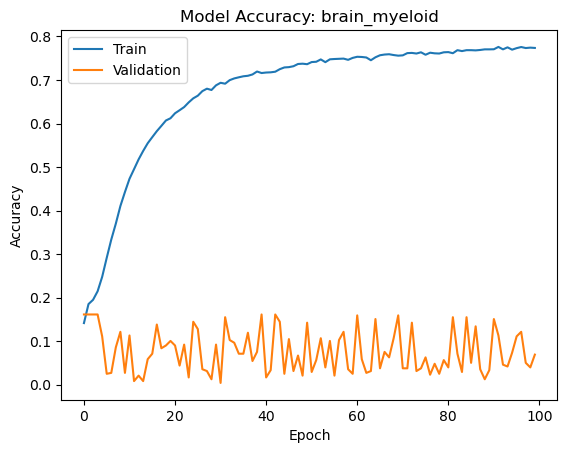

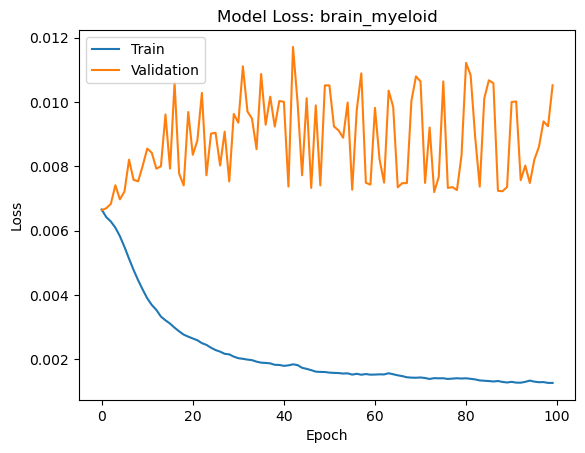

In [63]:
plot_history(history_pan, tissue_type=tissue_type)